# AlphaZero Algorithm - Testing of the NN training

# Import libraries / modules

In [1]:
# Python libraries
import time

# 3rd party libraries
import matplotlib.pyplot as plt
import numpy as np

# Game-related libraries
import games_mod # Games
import policy_mod # neural network
from play_mod import Play
import training_mod
from game_utils import DotDict, policy_player_mcts, random_player, match_ai

# Game, Training and Play Settings

In [2]:
# Game settings
game_settings = DotDict({
    "board_size": (3,3),
    "N": 3
})

# Self-play training settings
game_training_settings = DotDict({
    "comp_interval":100,
    "episods": 1000,
    "explore_steps": 50,
    "temp_threshold": [300, 0.01] #[x,y] means "up to x episods, applies y temperature"
})
# neural network settings
nn_training_settings = DotDict({
    "load_policy": False,
    "ai_ckp": "",
    "lr": .0001, 
    "weight_decay": 1.e-4,
})

# play settings
play_settings = DotDict({
    "explore_steps": 50,
    "temperature": 0.01                         
})

## Testing of the loss function

In [3]:
from mcts import process_policy
from replay_buffer import ReplayBuffer
import torch
import torch.nn as nn
import torch.optim as optim

buffer_size = 500
batch_size = 50
buffer = ReplayBuffer(buffer_size, batch_size)

In [4]:
from self_play import execute_self_play
policy = policy_mod.Policy()
temp = 1
wins = 0
draws = 0
losses = 0
explore_steps = 10
for j in range (100):
    new_exp = execute_self_play (game_settings, explore_steps, policy, temp)
    for i in range(len(new_exp)):
        buffer.add(new_exp[i])

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
def train(predicted_v, target_v, predicted_p, target_p):
    optimizer = optim.SGD(
            policy.parameters(),
            lr=nn_training_settings.lr,
            weight_decay=nn_training_settings.weight_decay,
    )
    
    
    #mse_loss_fc = nn.MSELoss()
    #mse_loss = mse_loss_fc(predicted_v, target_v)
    mse_loss = torch.sum((predicted_v - target_v)**2)

    loglist = torch.where(predicted_p > 0, torch.log(predicted_p) * target_p, torch.tensor(0.0))
    constant = torch.where(target_p > 0, torch.log(target_p) * target_p, torch.tensor(0.0))
    loss_loglist = -torch.sum(loglist)
    loss_constant = torch.sum(constant)
    

    loss = -torch.sum(loglist-constant) + mse_loss
    #loss = mse_loss
    
    loss_value = float(loss)
    optimizer.zero_grad()
    loss.backward()
    
    #nn.utils.clip_grad_value_(policy.parameters(), clip_value=1.0)
    
    optimizer.step()
    print ("Loss = {}, Loglist = {}, constant = {}".format(
        loss, loss_loglist, loss_constant))

    #loss.detach()
    return float(loss)

In [7]:
# test with 1 state
losses = []
policy = policy_mod.Policy()
for _ in range(200):
    samples = buffer.sample()
    all_states = torch.tensor(np.vstack([[[e.state] for e in samples if e is not None]]), 
                              dtype=torch.float, device=device)
    all_p = torch.tensor(np.vstack([e.p for e in samples if e is not None]), 
                         dtype=torch.float, device=device)
    
    all_v = torch.tensor(np.vstack([e.v for e in samples if e is not None]), 
                         dtype=torch.float, device=device)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #print ("Input : {}".format(input))

    predicted_p, predicted_v = policy.forward_batch(all_states)    
    target_p = torch.tensor(all_p, dtype=torch.float, device=device)
    target_v = torch.tensor(all_v, dtype=torch.float, device=device)
    losses.append(train(predicted_v, target_v, predicted_p, target_p))

Loss = 76.48554992675781, Loglist = 110.34210968017578, constant = -70.45030975341797
Loss = 79.06962585449219, Loglist = 110.19854736328125, constant = -68.85601806640625
Loss = 78.28089141845703, Loglist = 110.55245971679688, constant = -70.47846984863281
Loss = 79.8487319946289, Loglist = 110.91426849365234, constant = -71.79414367675781
Loss = 66.85430908203125, Loglist = 110.41156768798828, constant = -82.30001831054688
Loss = 78.67796325683594, Loglist = 110.79578399658203, constant = -72.2771987915039
Loss = 67.95124816894531, Loglist = 110.15672302246094, constant = -78.83380889892578
Loss = 84.09171295166016, Loglist = 110.54751586914062, constant = -73.95478057861328
Loss = 75.6239013671875, Loglist = 110.51043701171875, constant = -73.50759887695312
Loss = 67.0363998413086, Loglist = 110.0539321899414, constant = -77.44437408447266
Loss = 66.13883209228516, Loglist = 109.95855712890625, constant = -77.3813247680664
Loss = 69.84551239013672, Loglist = 110.21825408935547, cons

Loss = 64.74937438964844, Loglist = 110.35556030273438, constant = -75.8602523803711
Loss = 74.59205627441406, Loglist = 110.11445617675781, constant = -68.42814636230469
Loss = 63.04769515991211, Loglist = 110.40093231201172, constant = -78.8924331665039
Loss = 63.271026611328125, Loglist = 110.3072509765625, constant = -73.88976287841797
Loss = 85.917724609375, Loglist = 110.13703918457031, constant = -64.184326171875
Loss = 69.10468292236328, Loglist = 111.0836410522461, constant = -73.83063507080078
Loss = 77.18663024902344, Loglist = 111.39959716796875, constant = -79.49569702148438
Loss = 73.83518981933594, Loglist = 110.01810455322266, constant = -73.48026275634766
Loss = 75.72941589355469, Loglist = 110.42948150634766, constant = -69.13118743896484
Loss = 71.18453979492188, Loglist = 111.73946380615234, constant = -75.71793365478516
Loss = 69.99177551269531, Loglist = 110.27193450927734, constant = -80.09845733642578
Loss = 75.63679504394531, Loglist = 111.25626373291016, const

Loss = 63.07866668701172, Loglist = 110.59331512451172, constant = -75.91024780273438
Loss = 73.44956970214844, Loglist = 110.3608627319336, constant = -73.85765075683594


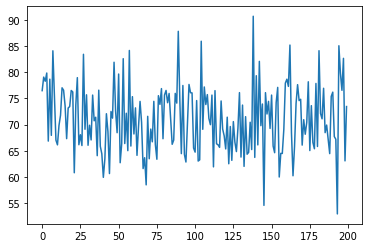

In [8]:
plt.plot(losses)